## Agenda

* Intro (20 min)
  * What is Theano and why should I care?
  * Installation
  * Configuration
* Basics (40 min)
  * Baby steps
  * Theano variables and functions
  * Shared variables and more on functions
  * Debugging
* Theano for Machine Learning (60 min)
  * Logistic regression
  * SVM
  * Kernels
  * Regularization
* Lasagne (?? min)
  * MLP
  * Convolutional neural network
  * Goodies (?)


Код доступен тут: https://github.com/dudevil/datafest-theano-tutorial/.

### Intro

Theano позволяет с помощью языка Python определять, компилировать и вычислять математические выражения.
Так что Theano это сразу много вещей:

* Язык для символьных вычислений
* Оптимизирующий компилятор
* Средства исполнения кода

### Installation

Dependencies:
     
   * System: **g++, BLAS**
   * Python: **NumPy, SciPy** 
   * Goodies: **CUDA, CuDNN**


Current release:
```
pip install Theano
```

Bleeding-edge:
```
pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
```

[Official instructions](http://deeplearning.net/software/theano/install.html#install)

### Configuration

~/.theanorc

```
    [global]
    device = gpu # cpu
    floatX = float32
    optimizer_including=cudnn 
    allow_gc = False # быстрее но использует больше памяти
    #exception_verbosity=high
    #optimizer = None  # полезно при отладке
    #profile = True
    #profile_memory = True

    [nvcc]
    fastmath = True
```

[More on configuration](http://deeplearning.net/software/theano/library/config.html)

### Getting help

Theano has great documentation:
   * http://deeplearning.net/software/theano/tutorial/
   * http://deeplearning.net/software/theano/index.html#documentation
   
Code samples:
   * http://deeplearning.net/tutorial/
   
And user community:
   * https://groups.google.com/forum/#!forum/theano-users

Don't be afraid to peek into the code:
   * https://github.com/Theano/Theano

## Basic operations

### Baby steps

In [1]:
import theano 
import theano.tensor as T

%pylab inline
figsize(8, 6)

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib


In [12]:
# doing stuff with theano

# declare theano variable
a = T.lscalar() 

# construct an expression
expression = 1 + 2 * a + a ** 2 

# compile a theano function
f = theano.function(
    inputs=[a],        # input
    outputs=expression  # output
)

# evaluate the expression
f(10)

array(121)

### Theano variables and functions

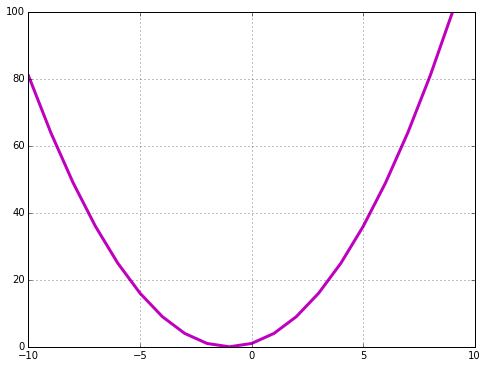

In [3]:
# only the declaration changes
a = T.lvector()

expression = 1 + 2 * a + a ** 2 

f = theano.function(
    inputs=[a],        # input
    outputs=expression  # output
)

arg = arange(-10, 10)
res = f(arg)

plot(arg, res, c='m', linewidth=3.)
grid()

In [4]:
# can do the same with matrices
x = T.dmatrix('x')
y = T.dmatrix('y')

z = x + 2 * y

f = theano.function([x, y], z)
f(ones((3, 3)), eye(3))

array([[ 3.,  1.,  1.],
       [ 1.,  3.,  1.],
       [ 1.,  1.,  3.]])

In [5]:
# broadcasting also works
x = T.dmatrix('x')
v = T.dvector('v')

z = v + x

f = theano.function([x, v], z)
f(ones((3, 4)), ones((4,)))

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.]])

In [7]:
# types should be handled with care
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function([x, v], z)
print f(ones((3, 4), dtype=float32), np.ones((4,), dtype=float32))
print f(ones((3, 4)), ones((4,)))

[[ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]]


TypeError: ('Bad input argument to theano function with name "<ipython-input-7-96f108ecb7cc>:7"  at index 0(0-based)', 'TensorType(float32, matrix) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function".', array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]]))

In [9]:
# or you can supress the exception
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function(
    inputs=[x, v],
    outputs=z,
    allow_input_downcast=True
)
print f(ones((3, 4), dtype=float64), ones((4,), dtype=float64))

[[ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]
 [ 2.  2.  2.  2.]]


### Shared variables and more on functions

In [54]:
# shared variables represent internal state
state = theano.shared(0)

i = T.iscalar('i')
inc = theano.function([i],
                      state,
                      # updates the shared variable value
                      updates=[(state, state+i)]) 
dec = theano.function([i],
                      state,
                      updates=[(state, state-i)])

# more than one function can update the shared variable
print state.get_value()
inc(1)
inc(1)
inc(1)
print state.get_value()
dec(2)
print state.get_value()

0
3
1


In [43]:
# we can also set the shared variable outside of the function
state.set_value(-15)
print state.get_value()

-15


In [10]:
# shared variables can in be inserted into the compurational graph
x = T.lscalar('x')
y = T.lscalar('y')
i = T.lscalar('i')

expression = (x - y) ** 2

state = theano.shared(0)

f = theano.function(
    inputs=[x, i],
    outputs=expression,
    updates=[(state, state+i)],
    # use the value at state as y
    givens={
        y : state
    }
)
print f(5, 1) # (5 - 0) ^ 2 = 25
print f(2, 1) # (2 - 1) ^ 2 = 1

25
1


In [11]:
# we can compute different outputs simultaneously
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    inputs=[x, y],
    outputs=[square, sqrt]
)
print f(5, 4)
print f(2, 2)

[array(81), array(3.0)]
[array(16), array(2.0)]


## Debugging

## Printing graphs

In [43]:
# we can compute different outputs simultaneously
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    inputs=[x, y],
    outputs=[square, sqrt]
)
# the sum get's computed only once
theano.printing.debugprint(f)

Elemwise{Sqr}[(0, 0)] [@A] ''   2
 |Elemwise{add,no_inplace} [@B] ''   0
   |x [@C]
   |y [@D]
Elemwise{sqrt,no_inplace} [@E] ''   1
 |Elemwise{add,no_inplace} [@B] ''   0


In [2]:
# define a theano expression
W = T.fmatrix('W')
b = T.fvector('b')
X = T.fmatrix('X')

expr = T.dot(X, W) + b
prob = 1 / (1 + T.exp(-expr))
pred = prob > 0.5

In [3]:
# and print it
theano.pprint(pred)

'gt((TensorConstant{1} / (TensorConstant{1} + exp((-((X \\dot W) + b))))), TensorConstant{0.5})'

In [69]:
theano.printing.debugprint(pred)

Elemwise{gt,no_inplace} [@A] ''   
 |Elemwise{true_div,no_inplace} [@B] ''   
 | |DimShuffle{x,x} [@C] ''   
 | | |TensorConstant{1} [@D]
 | |Elemwise{add,no_inplace} [@E] ''   
 |   |DimShuffle{x,x} [@F] ''   
 |   | |TensorConstant{1} [@D]
 |   |Elemwise{exp,no_inplace} [@G] ''   
 |     |Elemwise{neg,no_inplace} [@H] ''   
 |       |Elemwise{add,no_inplace} [@I] ''   
 |         |dot [@J] ''   
 |         | |X [@K]
 |         | |W [@L]
 |         |DimShuffle{x,0} [@M] ''   
 |           |b [@N]
 |DimShuffle{x,x} [@O] ''   
   |TensorConstant{0.5} [@P]


In [5]:
theano.printing.pydotprint(pred, outfile='pics/pred_graph.png', var_with_name_simple=True)  

The output file is available at pics/pred_graph.png


<img src="pics/pred_graph.png">

In [49]:
# define a theano expression
W_1 = T.fmatrix('W_1')
W_2 = T.fmatrix('W_2')
b_1 = T.fvector('b_1')
b_2 = T.fvector('b_2')
activation = lambda expr: 1 / (1 + T.exp(-expr))
X = T.fmatrix('X')
y = T.ivector('y')

d1 = T.dot(X, W_1) + b_1
a1 = activation(d1)
d2 = T.dot(a1, W_2) + b_2
prob = activation(d2)
loss = T.nnet.categorical_crossentropy(prob, y)

theano.printing.pydotprint(loss, outfile='pics/pred_biggraph.png', var_with_name_simple=True)  

The output file is available at pics/pred_biggraph.png


<img src="pics/pred_biggraph.png">
<img src="pics/escalated_quickly.jpeg">

More on graph visualizations: http://deeplearning.net/software/theano/tutorial/printing_drawing.html

### MonitorMode for debugging

In [128]:
def inspect_inputs(i, node, fn):
    print i, node, "input(s) value(s):", [input[0] for input in fn.inputs],

def inspect_outputs(i, node, fn):
    print "output(s) value(s):", [output[0] for output in fn.outputs]

x = theano.tensor.dscalar('x')
f = theano.function(inputs=[x], 
                    outputs=(5 * x),
                    mode=theano.compile.MonitorMode(
                        pre_func=inspect_inputs,
                        post_func=inspect_outputs))
f(3)

0 Elemwise{mul,no_inplace}(TensorConstant{5.0}, x) input(s) value(s): [array(5.0), array(3.0)] output(s) value(s): [array(15.0)]


array(15.0)

More debugging technics are available here: http://deeplearning.net/software/theano/tutorial/debug_faq.html

## Theano for Machine learining

#### Preparting data

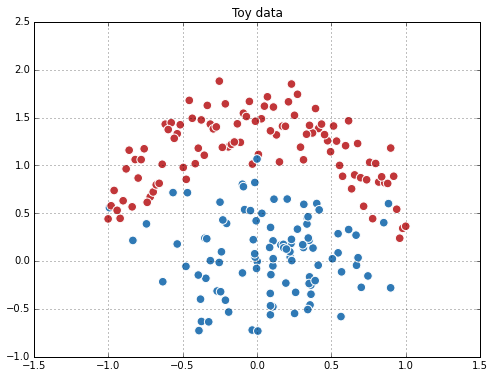

In [129]:
x1 = linspace(-1, 1, 100)
x2 = 1.5 - x1 ** 2 + random.normal(scale=0.2, size=100)
x3 = random.normal(scale=0.4, size=100)
x4 = random.normal(scale=0.4, size=100)

permutation = random.permutation(np.arange(200))
x = hstack((
    vstack((x1, x2)),
    vstack((x3, x4)))).T[permutation]
y = concatenate((
    zeros_like(x1),
    ones_like(x3)))[permutation]

# needed for pictures later
xx, yy = mgrid[-2:2:.01, -2:2:.01]
grid_arr = c_[xx.ravel(), yy.ravel()]

def plot_decision(predicts):
    probas = predicts.reshape(xx.shape)

    contour = contourf(xx, yy, probas, 25, cmap="RdBu", vmin=0, vmax=1)
    colorbar(contour)

    scatter(x[:,0], x[:, 1], c=y, s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)
    title("Some cool decision boundary")
    grid()
    
scatter(x[:,0], x[:, 1], c=y, s=75,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
title("Toy data")
grid()

### Logistic regression

In [130]:
# allocate parameters
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b
p_y_given_x = T.nnet.sigmoid(linear)
y_pred = p_y_given_x > 0.5

# define loss-function
loss = T.nnet.binary_crossentropy(p_y_given_x, Y).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=loss,
    updates=updates,
    allow_input_downcast=True
)

predict_proba = theano.function(
    [X],
    p_y_given_x,
    allow_input_downcast=True
)

In [131]:
## SGD is love SGD is life
batch_size = 4

for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.638073
[Epoch 010] Train loss: 0.318913
[Epoch 020] Train loss: 0.266675
[Epoch 030] Train loss: 0.245972
[Epoch 040] Train loss: 0.235109
[Epoch 050] Train loss: 0.228565
[Epoch 060] Train loss: 0.224286
[Epoch 070] Train loss: 0.221329
[Epoch 080] Train loss: 0.219204
[Epoch 090] Train loss: 0.217631
[Epoch 100] Train loss: 0.216441
[Epoch 110] Train loss: 0.215523
[Epoch 120] Train loss: 0.214806
[Epoch 130] Train loss: 0.214238
[Epoch 140] Train loss: 0.213783
[Epoch 150] Train loss: 0.213417
[Epoch 160] Train loss: 0.213119
[Epoch 170] Train loss: 0.212875
[Epoch 180] Train loss: 0.212674
[Epoch 190] Train loss: 0.212509
[Epoch 200] Train loss: 0.212371
[Epoch 210] Train loss: 0.212257
[Epoch 220] Train loss: 0.212161
[Epoch 230] Train loss: 0.212080
[Epoch 240] Train loss: 0.212013
[Epoch 250] Train loss: 0.211956
[Epoch 260] Train loss: 0.211907
[Epoch 270] Train loss: 0.211867
[Epoch 280] Train loss: 0.211832
[Epoch 290] Train loss: 0.211803
[Epoch 300

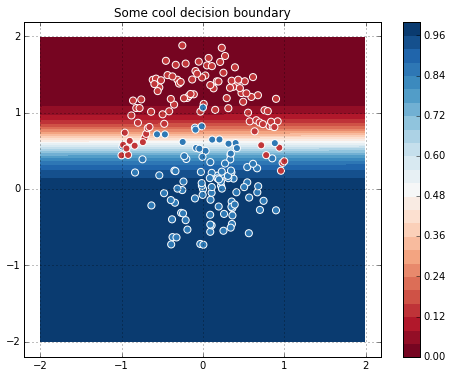

In [132]:
probas = predict_proba(grid_arr)
plot_decision(probas)

### SVM

In [ ]:
# reset parameters
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    [X, Y],
    [loss],
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    [X],
    linear > 0,
    allow_input_downcast=True
)

INFO (theano.gof.compilelock): Refreshing lock /home/dudevil/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/dudevil/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock


In [97]:
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = np.mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.530719
[Epoch 010] Train loss: 0.125924
[Epoch 020] Train loss: 0.106869
[Epoch 030] Train loss: 0.100274
[Epoch 040] Train loss: 0.095611
[Epoch 050] Train loss: 0.092193
[Epoch 060] Train loss: 0.090120
[Epoch 070] Train loss: 0.088257
[Epoch 080] Train loss: 0.088169
[Epoch 090] Train loss: 0.086988
[Epoch 100] Train loss: 0.084946
[Epoch 110] Train loss: 0.084379
[Epoch 120] Train loss: 0.084354
[Epoch 130] Train loss: 0.082558
[Epoch 140] Train loss: 0.082862
[Epoch 150] Train loss: 0.081033
[Epoch 160] Train loss: 0.080373
[Epoch 170] Train loss: 0.080760
[Epoch 180] Train loss: 0.078818
[Epoch 190] Train loss: 0.078179
[Epoch 200] Train loss: 0.077622
[Epoch 210] Train loss: 0.076089
[Epoch 220] Train loss: 0.077565
[Epoch 230] Train loss: 0.075631
[Epoch 240] Train loss: 0.075526
[Epoch 250] Train loss: 0.074750
[Epoch 260] Train loss: 0.076711
[Epoch 270] Train loss: 0.075783
[Epoch 280] Train loss: 0.076496
[Epoch 290] Train loss: 0.074620
[Epoch 300

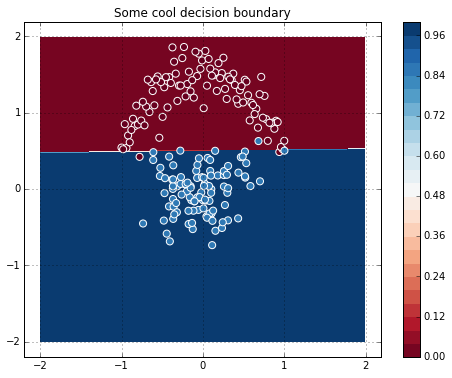

In [98]:
preds = predict(grid_arr)
plot_decision(preds)

### "Kernel" trick

In [38]:
# meet theano's scan:
# allocate variable
i = T.lscalar("i")

# fn parameters: sequences (if any), prior result(s) (if needed), non-sequences (if any)
# the sequences argument is ommited in this example
result, updates = theano.scan(fn=lambda prior_result, i: prior_result * i,
                              # initialize the output
                              outputs_info=T.ones_like(i),
                              # pass input as non sequence
                              non_sequences=i,
                              # this many iterations
                              n_steps=3)

# compile the function
poly = theano.function(inputs=[i], 
                        outputs=result,
                        updates=updates, # actually safe to omit in this case
                        allow_input_downcast=True)
poly(5)

array([  5,  25, 125])

In [16]:
# meet theano's scan 2:
# allocate variable
I = T.lmatrix("I")

# fn parameters: sequences (if any), prior result(s) (if needed), non-sequences (if any)
# the sequences argument is ommited in this example
result, updates = theano.scan(fn=lambda prior_result, I: prior_result * I,
                              # initialize the output
                              outputs_info=T.ones_like(I),
                              # pass input as non sequence
                              non_sequences=I,
                              # this many iterations
                              n_steps=2)

# x  y  -> x  y  x^2  y^2
# x' y' -> x' y' x'^2 y'^2

output = result.dimshuffle(1, 0, 2).reshape((result.shape[1], 
                                             result.shape[0] * result.shape[2]))
# compile the function
poly = theano.function(inputs=[I], 
                        outputs=output,
                        updates=updates, # actually safe to omit in this case
                        allow_input_downcast=True)
output = poly((np.arange(6) + 1).reshape(3, 2))
output

array([[ 1,  2,  1,  4],
       [ 3,  4,  9, 16],
       [ 5,  6, 25, 36]])

More documentation on looping in Theano: http://deeplearning.net/software/theano/library/scan.html

In [38]:
# reset parameters
def poly(inp, degree=2):
  
    result, updates = theano.scan(fn=lambda prior_result, inp: prior_result * inp,
                                  # initialize the output
                                  outputs_info=T.ones_like(inp),
                                  # pass input as non sequence
                                  non_sequences=inp,
                                  # this many iterations
                                  n_steps=degree)
    return result.dimshuffle(1, 0, 2).reshape((result.shape[1], 
                                               result.shape[0] * result.shape[2]))

# reset parameters
W = theano.shared(
    value=numpy.zeros((8, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)
# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(poly(X, degree=2), W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    out[loss],
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    [X],
    linear > 0,
    allow_input_downcast=True
)

In [39]:
batch_size = 4
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.479468
[Epoch 010] Train loss: 0.108716
[Epoch 020] Train loss: 0.084401
[Epoch 030] Train loss: 0.075915
[Epoch 040] Train loss: 0.072694
[Epoch 050] Train loss: 0.072048
[Epoch 060] Train loss: 0.071703
[Epoch 070] Train loss: 0.071438
[Epoch 080] Train loss: 0.070828
[Epoch 090] Train loss: 0.070798
[Epoch 100] Train loss: 0.070651
[Epoch 110] Train loss: 0.070585
[Epoch 120] Train loss: 0.070497
[Epoch 130] Train loss: 0.070405
[Epoch 140] Train loss: 0.070338
[Epoch 150] Train loss: 0.070182
[Epoch 160] Train loss: 0.070211
[Epoch 170] Train loss: 0.070258
[Epoch 180] Train loss: 0.069990
[Epoch 190] Train loss: 0.069964
[Epoch 200] Train loss: 0.069872
[Epoch 210] Train loss: 0.069797
[Epoch 220] Train loss: 0.069724
[Epoch 230] Train loss: 0.069632
[Epoch 240] Train loss: 0.069566
[Epoch 250] Train loss: 0.069521
[Epoch 260] Train loss: 0.069343
[Epoch 270] Train loss: 0.069163
[Epoch 280] Train loss: 0.069264
[Epoch 290] Train loss: 0.069219
[Epoch 300

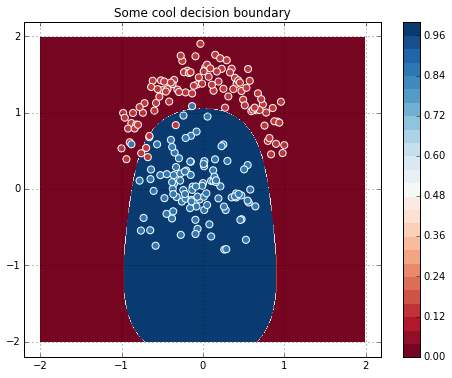

In [40]:
preds = predict(grid_arr)
plot_decision(preds)

### Regularization

In [110]:
# reset parameters
W = theano.shared(
    value=zeros((8, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)
# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(poly(X, degree=4), W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean() + 1e-3 * T.sum(W ** 2)

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=loss,
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    inputs=[X],
    linear > 0,
    allow_input_downcast=True
)

In [111]:
batch_size = 4
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

[Epoch 000] Train loss: 0.482177
[Epoch 010] Train loss: 0.104709
[Epoch 020] Train loss: 0.086824
[Epoch 030] Train loss: 0.076717
[Epoch 040] Train loss: 0.072243
[Epoch 050] Train loss: 0.070346
[Epoch 060] Train loss: 0.068640
[Epoch 070] Train loss: 0.067611
[Epoch 080] Train loss: 0.066775
[Epoch 090] Train loss: 0.065679
[Epoch 100] Train loss: 0.065352
[Epoch 110] Train loss: 0.064007
[Epoch 120] Train loss: 0.064243
[Epoch 130] Train loss: 0.063869
[Epoch 140] Train loss: 0.063563
[Epoch 150] Train loss: 0.063274
[Epoch 160] Train loss: 0.062974
[Epoch 170] Train loss: 0.062368
[Epoch 180] Train loss: 0.062462
[Epoch 190] Train loss: 0.061808
[Epoch 200] Train loss: 0.062025
[Epoch 210] Train loss: 0.061426
[Epoch 220] Train loss: 0.061675
[Epoch 230] Train loss: 0.061489
[Epoch 240] Train loss: 0.061355
[Epoch 250] Train loss: 0.060763
[Epoch 260] Train loss: 0.061103
[Epoch 270] Train loss: 0.060664
[Epoch 280] Train loss: 0.060875
[Epoch 290] Train loss: 0.060077
[Epoch 300

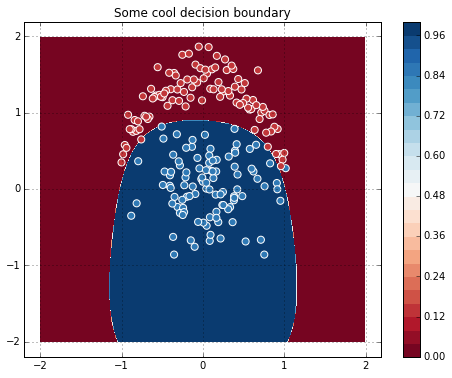

In [112]:
preds = predict(grid_arr)
plot_decision(preds)